In [6]:
%%capture
from google.colab import drive

drive.mount("/content/drive")

%cd /content/drive/MyDrive/nyu-stuff/2023-fall/DS-UA\ 301\ Advanced\ DS/final_project

%pip install -r requirements.txt
%pip install wandb -Uq
import pandas
import numpy
import json5
import functools
import json
from matplotlib import pyplot
from typing import Optional, Any, Coroutine, Union, Dict, List
import nltk
from nltk.corpus import stopwords
import string
import contractions
import torch
import wandb
import sklearn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("stopwords")
nltk.download("punkt")


def get_best_torch_device():
    if torch.cuda.is_available():  # CUDA
        return "cuda"
    elif torch.backends.mps.is_available():  # Apple Silicon / GPU
        return "mps"
    else:  # Fallback to CPU
        return "cpu"

In [2]:
# Configure hyperparameters (+ random state)
random_state = 13117

device = get_best_torch_device()
print(f"Currently using {device.upper()} for training!")

Currently using CUDA for training!


In [5]:
%ls data/

amazon_reviews.zip                  labels.csv
balanced_data.csv                   sweep_result_loss_mp_fast_final.pickle
balanced_with_labels.csv            sweep_result_loss_mp_fast.pickle
Cell_Phones_and_Accessories_5.json  sweep_result_loss_mp.pickle
checkpoints/                        train_results.csv
cleaned_data.csv                    wandb_runs.csv


In [12]:
trained_models = torch.load("data/sweep_result_loss_mp_fast_final_2.pickle")

In [13]:
len(trained_models)

32

In [14]:
trained_models_sorted = dict(sorted(trained_models.items()))

In [15]:
print(
    "Here are the losses from trained combinations in increasing order:\n",
    "\n\t".join([] + list([str(key) for key in trained_models_sorted.keys()])),
)

Here are the losses from trained combinations in increasing order:
 0.6031082272529602
	0.6042802333831787
	0.6088830828666687
	0.6103984117507935
	0.6322068572044373
	0.6373109817504883
	0.6407189965248108
	0.640744149684906
	0.6446128487586975
	0.6463202238082886
	0.6714719533920288
	0.6718466281890869
	0.6725099086761475
	0.6727628707885742
	0.6801438331604004
	0.6820995211601257
	0.6931231617927551
	0.7003363370895386
	0.7971276044845581
	0.798759400844574
	0.8037689328193665
	0.8166170120239258
	0.8266960978507996
	0.8719387054443359
	0.9005738496780396
	0.9130786657333374
	0.9303101897239685
	1.1809269189834595
	1.212859034538269
	1.5968811511993408
	1.6210702657699585
	1.6502794027328491


In [53]:
keys = list(trained_models_sorted.keys())
props_best = trained_models[keys[0]]

In [20]:
print("The model with best results is using the following hyperparameters:")

for k, v in props_best["config"].items():
    print(f"\t{k}: {v}")

print("Which yields the following results: ")

for k, v in props_best.items():
    if k in ["result_df", "chkpt", "config"]:
        continue

    print(f"\t{k}: {v}")

The model with best results is using the following hyperparameters:
	activation_func: relu
	batch_size: 8192
	is_batch_norm: True
	learning_rate: 0.1
	n_epochs: 128
	n_layers: 3
	optimizer: adam
Which yields the following results: 
	val_loss: 0.6031082272529602
	val_acc: 0.7202
	test_acc: 0.715


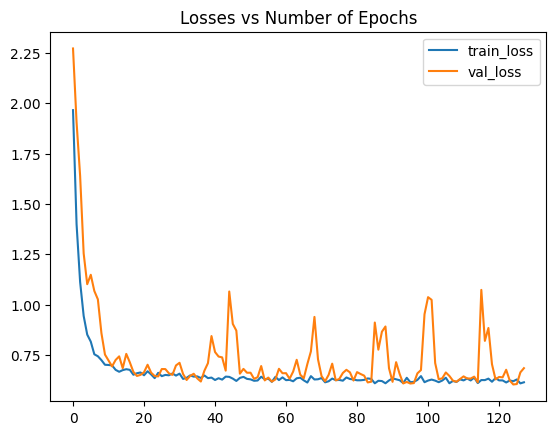

In [21]:
df_results = props_best["result_df"]

# train_loss and val_loss vs epoch
pyplot.plot(df_results["train_loss"], label="train_loss")
pyplot.plot(df_results["val_loss"], label="val_loss")
pyplot.legend()
pyplot.title(f"Losses vs Number of Epochs")
pyplot.show()

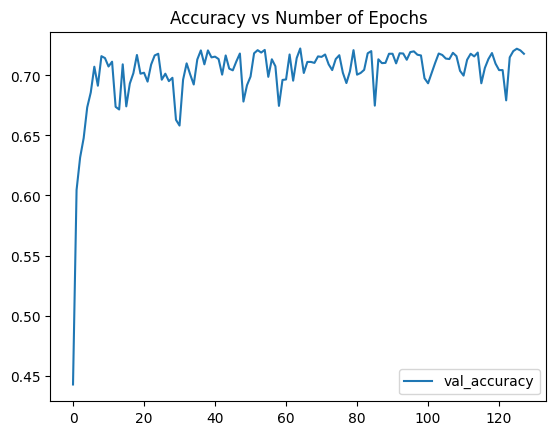

In [22]:
pyplot.plot(df_results["val_accuracy"], label="val_accuracy")
pyplot.title(f"Accuracy vs Number of Epochs")
pyplot.legend()

In [43]:
columns = list(
    set(
        list(props_best["config"].keys())  # Weights and Biases config
        + [
            k for k in props_best.keys() if k not in ["config", "result_df", "chkpt"]
        ]  # telemetry data
        + ["best_epoch"]  # Internal telemetry data
    )
)

In [44]:
rows = []

for k, v in trained_models_sorted.items():
    values = {}

    for key, value in v.items():
        if key in columns:
            values[key] = value

    for key, value in v["config"].items():
        if key in columns:
            values[key] = value

    values["best_epoch"] = v["chkpt"]["epoch"]

    val_arr = [values[key] for key in columns]
    rows.append(val_arr)

df_stats = pandas.DataFrame(columns=columns, data=rows)

In [45]:
df_stats

,n_epochs,test_acc,n_layers,is_batch_norm,optimizer,val_loss,batch_size,activation_func,val_acc,learning_rate,best_epoch
0,128,0.7150,3,True,adam,0.603108,8192,relu,0.7202,0.100,124
1,128,0.6794,4,True,adam,0.604280,4096,relu,0.7168,0.100,96
2,128,0.7078,3,True,adam,0.608883,8192,leaky_relu,0.7178,0.100,105
3,128,0.7080,2,True,adam,0.610398,8192,relu,0.7224,0.100,111
4,128,0.7132,3,True,adam,0.632207,4096,leaky_relu,0.7180,0.010,127
5,128,0.7006,3,True,sgd,0.637311,4096,leaky_relu,0.7178,0.100,123
6,128,0.7152,2,True,sgd,0.640719,4096,relu,0.7168,0.100,127
7,128,0.6470,4,True,adam,0.640744,4096,relu,0.7184,0.010,118
8,128,0.7098,2,True,sgd,0.644613,4096,relu,0.7148,0.100,120
9,128,0.7144,2,True,sgd,0.646320,4096,leaky_relu,0.7154,0.100,126


In [46]:
df_stats.describe()

,n_epochs,test_acc,n_layers,val_loss,batch_size,val_acc,learning_rate,best_epoch
count,32.0,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,128.0,0.704412,2.906250,0.832305,6400.000000,0.716725,0.041719,121.468750
std,0.0,0.015511,0.777065,0.299357,2064.450063,0.002583,0.045907,8.028113
min,128.0,0.647000,2.000000,0.603108,4096.000000,0.711000,0.005000,96.000000
25%,128.0,0.700050,2.000000,0.643646,4096.000000,0.715300,0.005000,119.750000
50%,128.0,0.710300,3.000000,0.687611,8192.000000,0.716800,0.010000,125.500000
75%,128.0,0.713300,3.250000,0.879097,8192.000000,0.718450,0.100000,127.000000
max,128.0,0.719200,4.000000,1.650279,8192.000000,0.722400,0.100000,127.000000


In [47]:
df_not_overfit = df_stats[df_stats["val_acc"] < df_stats["test_acc"]]

In [49]:
df_not_overfit

,n_epochs,test_acc,n_layers,is_batch_norm,optimizer,val_loss,batch_size,activation_func,val_acc,learning_rate,best_epoch
12,128,0.7174,3,True,sgd,0.672510,8192,relu,0.7164,0.1,117
13,128,0.7192,3,True,sgd,0.672763,8192,relu,0.7176,0.1,125


In [52]:
good_keys = df_not_overfit["val_loss"].tolist()

In [54]:
good_model_1, good_model_2 = tuple([trained_models[k] for k in good_keys])

In [62]:
def describe_model(model_info, name: str = ""):
    print(f"The model {name} is using the following hyperparameters:")

    for k, v in model_info["config"].items():
        print(f"\t{k}: {v}")

    print("Which yields the following results: ")

    for k, v in model_info.items():
        if k in ["result_df", "chkpt", "config"]:
            continue

        print(f"\t{k}: {v}")

    df_results = model_info["result_df"]

    # train_loss and val_loss vs epoch
    pyplot.plot(df_results["train_loss"], label="train_loss")
    pyplot.plot(df_results["val_loss"], label="val_loss")
    pyplot.legend()
    pyplot.title(f"Losses vs Number of Epochs ({name})")
    pyplot.show()

    pyplot.plot(df_results["val_accuracy"], label="val_accuracy")
    pyplot.title(f"Accuracy vs Number of Epochs ({name})")
    pyplot.legend()
    pyplot.show()

The model good_model_1 is using the following hyperparameters:
	activation_func: relu
	batch_size: 8192
	is_batch_norm: True
	learning_rate: 0.1
	n_epochs: 128
	n_layers: 3
	optimizer: sgd
Which yields the following results: 
	val_loss: 0.6725099086761475
	val_acc: 0.7164
	test_acc: 0.7174


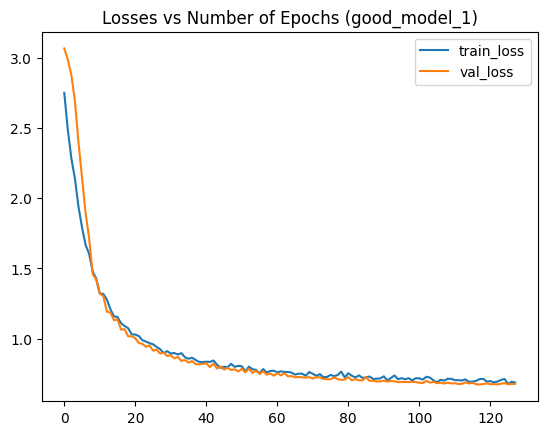

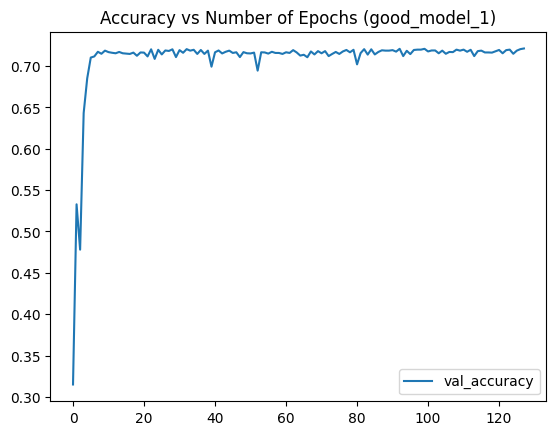

In [63]:
describe_model(good_model_1, "good_model_1")

The model good_model_2 is using the following hyperparameters:
	activation_func: relu
	batch_size: 8192
	is_batch_norm: True
	learning_rate: 0.1
	n_epochs: 128
	n_layers: 3
	optimizer: sgd
Which yields the following results: 
	val_loss: 0.6727628707885742
	val_acc: 0.7176
	test_acc: 0.7192


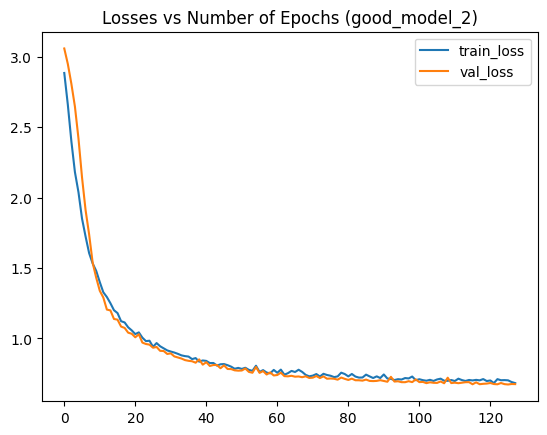

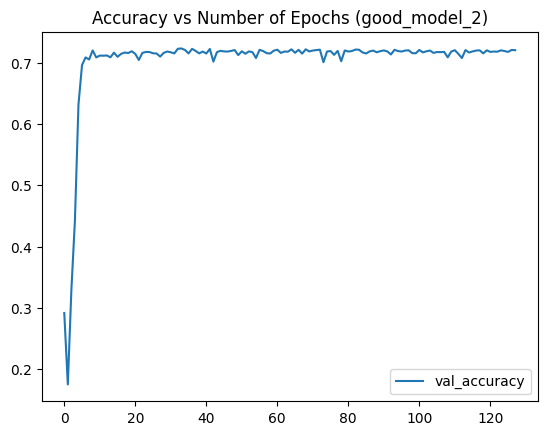

In [64]:
describe_model(good_model_2, "good_model_2")